# Poverty in Marseille with granular data

## Import modules

In [1]:
import io
import re
import urllib3
import warnings
import zipfile

import geopandas
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import py7zr
import requests
from shapely.geometry import Polygon, Point

from pynsee.geodata.get_geodata import get_geodata

## Retrieve sample dataset from INSEE (filter VAR departement)

In [2]:
URL = "https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_csv.zip"

def _download_data_var_departement(url):

    try:
        # Note: the dataset will be cached on your local disk at first download
        return pd.read_parquet("poverty_marseille.parquet")
    except FileNotFoundError:
        pass

    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", urllib3.exceptions.InsecureRequestWarning
        )

        results = requests.get(url, verify=False)
    obj = io.BytesIO(results.content)

    with zipfile.ZipFile(obj, "r") as zip_ref:
        sevenfile = zip_ref.namelist()[0]
        obj = io.BytesIO(zip_ref.read(sevenfile))

    with py7zr.SevenZipFile(obj, mode="r") as z:
        file = [
            f for f in z.list() if re.match(".*metropole.csv$", f.filename)
        ]
        file = file[0]
        with z.read([file.filename])[file.filename] as f:
            obj = io.BytesIO(f.read())

    data = pd.read_csv(obj, dtype="str", sep=",")

    # filter data on Var departement
    data13 = (
        data[data.Depcom.str.contains("^13")].reset_index(drop=True).copy()
    )

    data13.to_parquet("poverty_marseille.parquet")

    return data13


data = _download_data_var_departement(URL)

## make geographical squares and construct GeoDataFrame

In [3]:
# Extract latitude and longitude from data
geoms = data["IdINSPIRE"].str.extractall("^CRS3035RES200mN(?P<lat>[0-9]+)E(?P<lon>[0-9]+)$")

# construct squares using translations 
sideLength=200
north_west = geopandas.GeoSeries(geopandas.points_from_xy(x=geoms["lon"], y=geoms["lat"]), crs=3035)
north_east = north_west.translate(xoff=sideLength, yoff=0)
south_east = north_east.translate(xoff=0, yoff=-sideLength)
south_west = south_east.translate(xoff=-sideLength, yoff=0)
geoms = geopandas.pd.concat([north_west, north_east, south_east, south_west], axis=1).apply(Polygon, axis=1)
geoms.name = "geometry"

# join to initial data
data = geopandas.GeoDataFrame(data.join(geoms), crs=3035)

## download geographical data from IGN API using pynsee

In [4]:
arr = get_geodata(
    "ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal", crs="EPSG:3035"
)

# filter geographical limits of Marseille city
marseille = arr[arr.nom.str.contains("Marseille")]
geoMarseille = marseille.geometry.union_all()
marseilleMap = geopandas.GeoDataFrame(marseille, crs=3035)

## compute percentage of poor households for each 200m square

In [5]:
# filter dataset on Marseill city

data["check_marseille"] = data.intersects(geoMarseille)
dataMarseille = data[data["check_marseille"]].reset_index(drop=True)

# compute percentage of poor households for each 200m square
cols = ["Men_pauv", "Men"]
dataMarseille[cols] = dataMarseille[cols].apply(pd.to_numeric, errors="coerce")
dataMarseille["Men_pauv_pct"] = (
    dataMarseille["Men_pauv"] / dataMarseille["Men"] * 100
)

## make plot

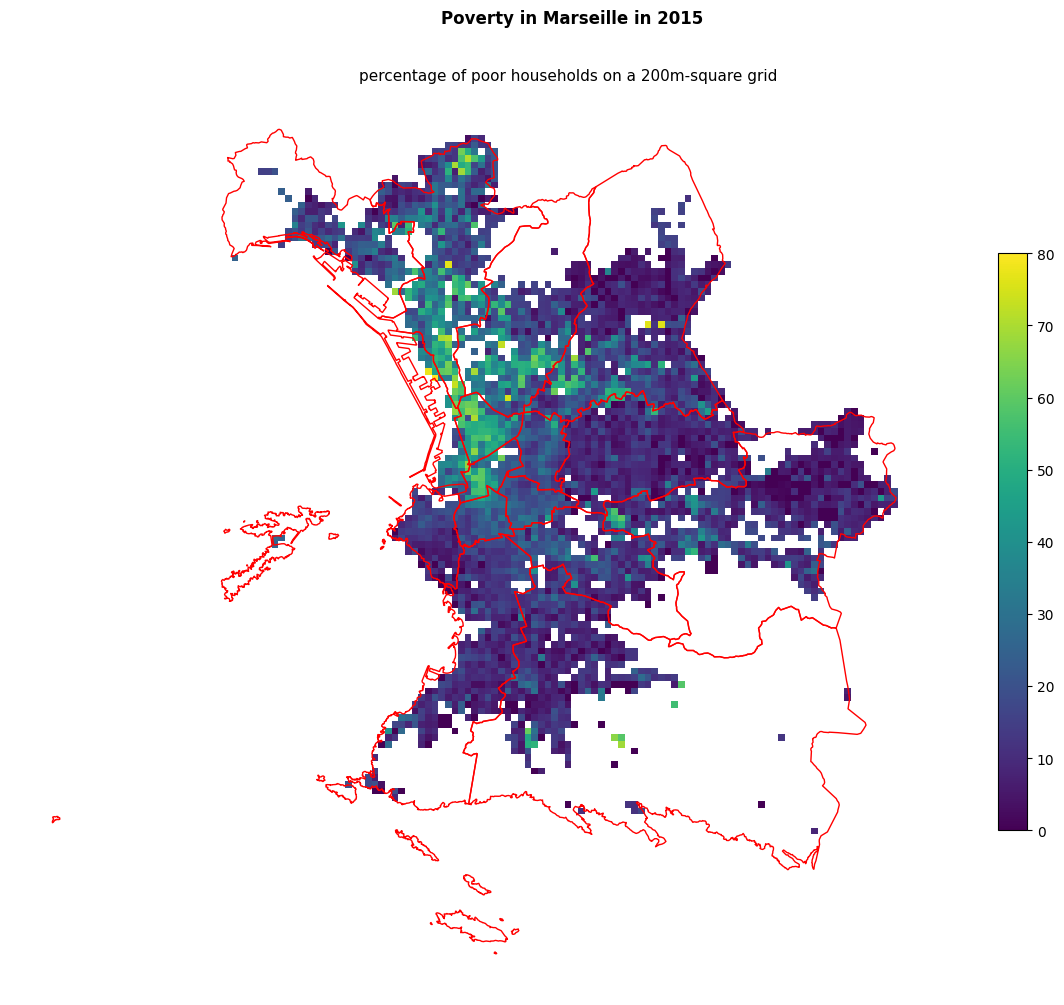

In [6]:
# make plot
ax = dataMarseille.plot(
    column="Men_pauv_pct",
    cmap=cm.viridis,
    legend=True,
    legend_kwds={"shrink": 0.5},
    figsize=(15, 15),
)
marseilleMap.plot(ax=ax, edgecolor="red", color="none")
ax.set_axis_off()
plt.suptitle("Poverty in Marseille in 2015", y=0.85, fontweight="bold")
plt.title(
    "percentage of poor households on a 200m-square grid", size=11, x=0.6
)
plt.show()